In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
import mdtraj as md
import numpy as np
from tqdm import tqdm

In [2]:
from westpa_helpers import *

In [3]:
home_path="/media/DATA_18_TB_1/awaghili/WESTPA_CG/harmonic_mix_chignolin_mabbin/westpa_prop"
os.chdir(home_path)

In [4]:
sim_config = extract_simulation_config()

# Will be needed to unpicfinished_maskkle the TICA models
import sys
sys.path.append(sim_config['cgschnet_path'])

In [5]:
topology = mdtraj.load(sim_config['topology_path']).topology
traj_dirs = sorted(glob.glob(f"./traj_segs/*/*"))

trajectories = []
for td in tqdm(traj_dirs):
    try:
        seg_npz_data = np.load(os.path.join(td, "seg.npz"))
    except Exception as e:
        # Don't error out if we hit an unfinished segment
        print("Error appending ", td)
        print(e)
    traj = mdtraj.Trajectory(xyz=seg_npz_data["pos"]*0.1, topology=topo)
    trajectories.append(traj)

2025-06-06 00:17:18,077 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-06-06 00:17:18,077 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
100%|██████████| 9285/9285 [00:13<00:00, 667.70it/s] 


In [6]:
tica_components = [0] # Set this for TICA components, eg range(2)

In [7]:
tica_model = load_tica_model(sim_config["tica_model_path"])
components = sim_config["components"] if tica_components is None else tica_components

# trajectories = trajectories[int(len(trajectories)*0.1):]

component_values = []
for traj in tqdm(trajectories):
    values = calculate_component_values(tica_model, traj, components)
    component_series = np.array(values[components[0]])  # Only the first component
    component_values.append(component_series)

    
# Step 3: Bin component values
num_bins = 80
component_min = min([min(cv) for cv in component_values])
component_max = max([max(cv) for cv in component_values])
component_bins = np.linspace(component_min, component_max, num_bins + 1)

binned_components = [
    np.clip((num_bins * (cv - component_min) / (component_max - component_min)).astype(int), None, num_bins - 1)
    for cv in component_values
]

# Step 4: Construct transition matrix
transition_matrix = np.zeros((num_bins, num_bins), dtype=int)
for binned_traj in binned_components:
    for j in range(len(binned_traj) - 1):
        transition_matrix[binned_traj[j], binned_traj[j + 1]] += 1

print("Transition matrix built.")


/home/md-ml/miniconda3/envs/andy-reports-3/lib/python3.11/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceModel from version 0.4.5 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/md-ml/miniconda3/envs/andy-reports-3/lib/python3.11/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceKoopmanModel from version 0.4.5 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
100%|██████████| 3095/3095 [00:00<00:00, 12492.08it/s]

Transition matrix built.


In [8]:
transition_matrix

array([[0, 2, 1, ..., 0, 0, 0],
       [3, 6, 8, ..., 0, 0, 0],
       [0, 9, 8, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
transition_prob_matrix = transition_matrix.astype(np.double)/np.sum(transition_matrix, axis=1, keepdims=True)
transition_prob_matrix = np.nan_to_num(transition_prob_matrix, nan=0.0)

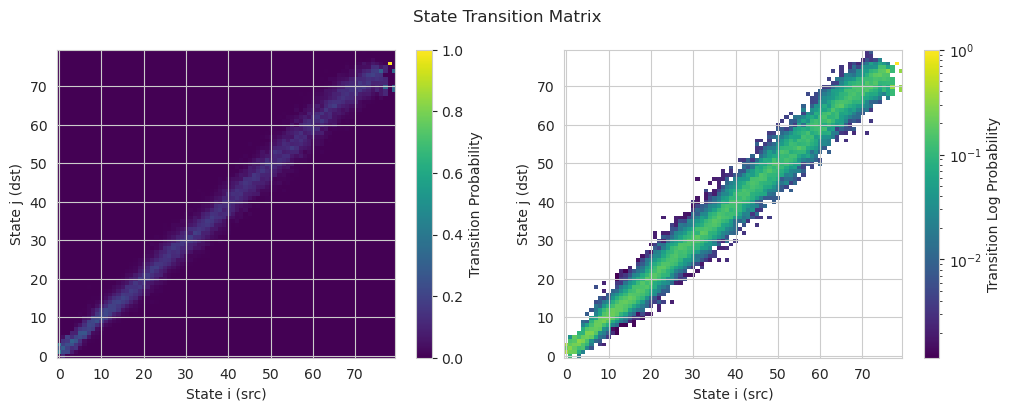

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
im0 = axes[0].imshow(transition_prob_matrix.T, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(im0, label='Transition Probability', ax=axes[0])
axes[0].set_xlabel('State i (src)')
axes[0].set_ylabel('State j (dst)')
# axes[0].set_title('Transition Matrix')

im1 = axes[1].imshow(transition_prob_matrix.T, origin='lower', aspect='auto', cmap='viridis', norm="log")
plt.colorbar(im1, label='Transition Log Probability', ax=axes[1])
axes[1].set_xlabel('State i (src)')
axes[1].set_ylabel('State j (dst)')
axes[1].set_title('')

fig.suptitle("State Transition Matrix")
pass

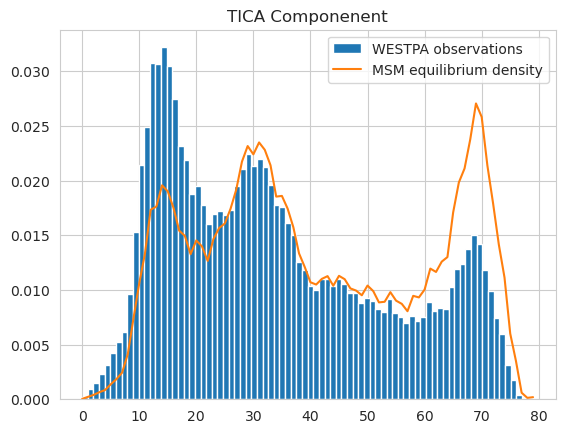

In [11]:
# Linear algebra by ChatGPT
# Solve for the stationary distribution
eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]

assert stationary_vector.shape[1] == 1, "Stationary distribution is not unique"

# Normalize the stationary vector to sum to 1
stationary_distribution = stationary_vector / np.sum(stationary_vector)
stationary_distribution = stationary_distribution.real.flatten()

plt.title(f"TICA Componenent")
plt.hist(np.concatenate(binned_components), bins=num_bins, density=True, label="WESTPA observations")
plt.plot(stationary_distribution, label="MSM equilibrium density")
plt.legend()
pass

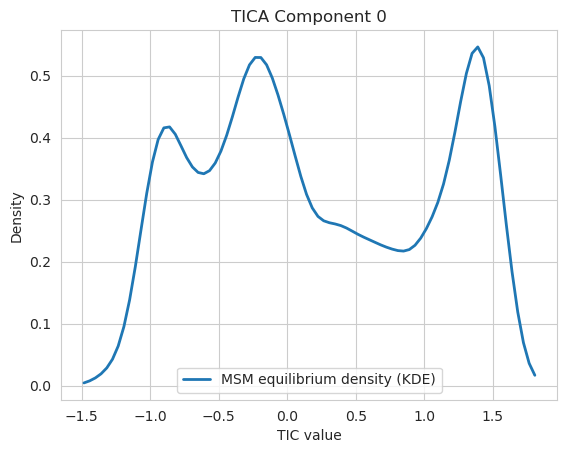

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Solve for the stationary distribution
eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]

assert stationary_vector.shape[1] == 1, "Stationary distribution is not unique"

# Normalize the stationary vector to sum to 1
stationary_distribution = stationary_vector / np.sum(stationary_vector)
stationary_distribution = stationary_distribution.real.flatten()

# Create KDE for stationary distribution
# Assume `bin_centers` corresponds to the center of your histogram bins
bin_centers = 0.5 * (component_bins[:-1] + component_bins[1:])
kde = gaussian_kde(bin_centers, weights=stationary_distribution, bw_method=0.1)
kde_values = kde(bin_centers)

# Plot histogram and KDE
plt.title("TICA Component " + str(tica_components[0]))
plt.plot(bin_centers, kde_values, label="MSM equilibrium density (KDE)", linewidth=2)
plt.legend()
plt.xlabel("TIC value")
plt.ylabel("Density")
plt.show()

In [15]:
from report_generator.tica_plots import calc_atom_distance

tica_model = load_tica_model(sim_config["tica_model_path"])
all_native_file_strided_file = "/media/DATA_18_TB_1/andy/benchmark_cache/chignolin_native_trajs_CG_stride100_nrNativePaths373_300K.pkl"

with open(all_native_file_strided_file, 'rb') as all_native_file_strided:
    native_trajs_strided = pickle.load(all_native_file_strided)
    
    native_proj_datas: list[np.typing.NDArray]  = tica_model.decompose([calc_atom_distance(x.trajectory) for x in tqdm(native_trajs_strided)])
    assert not np.isnan(native_proj_datas).any()
    
    strideNative = 10
    native_proj_datas_concat = np.concatenate(native_proj_datas)[::strideNative]




100%|██████████| 373/373 [00:01<00:00, 274.00it/s]

100%|██████████| 373/373 [00:00<00:00, 30681.40it/s]



100%|██████████| 3095/3095 [00:00<00:00, 12564.36it/s]

100%|██████████| 3095/3095 [00:00<00:00, 11477.85it/s]

100%|██████████| 3095/3095 [00:00<00:00, 12701.02it/s]

100%|██████████| 3095/3095 [00:00<00:00, 14518.99it/s]


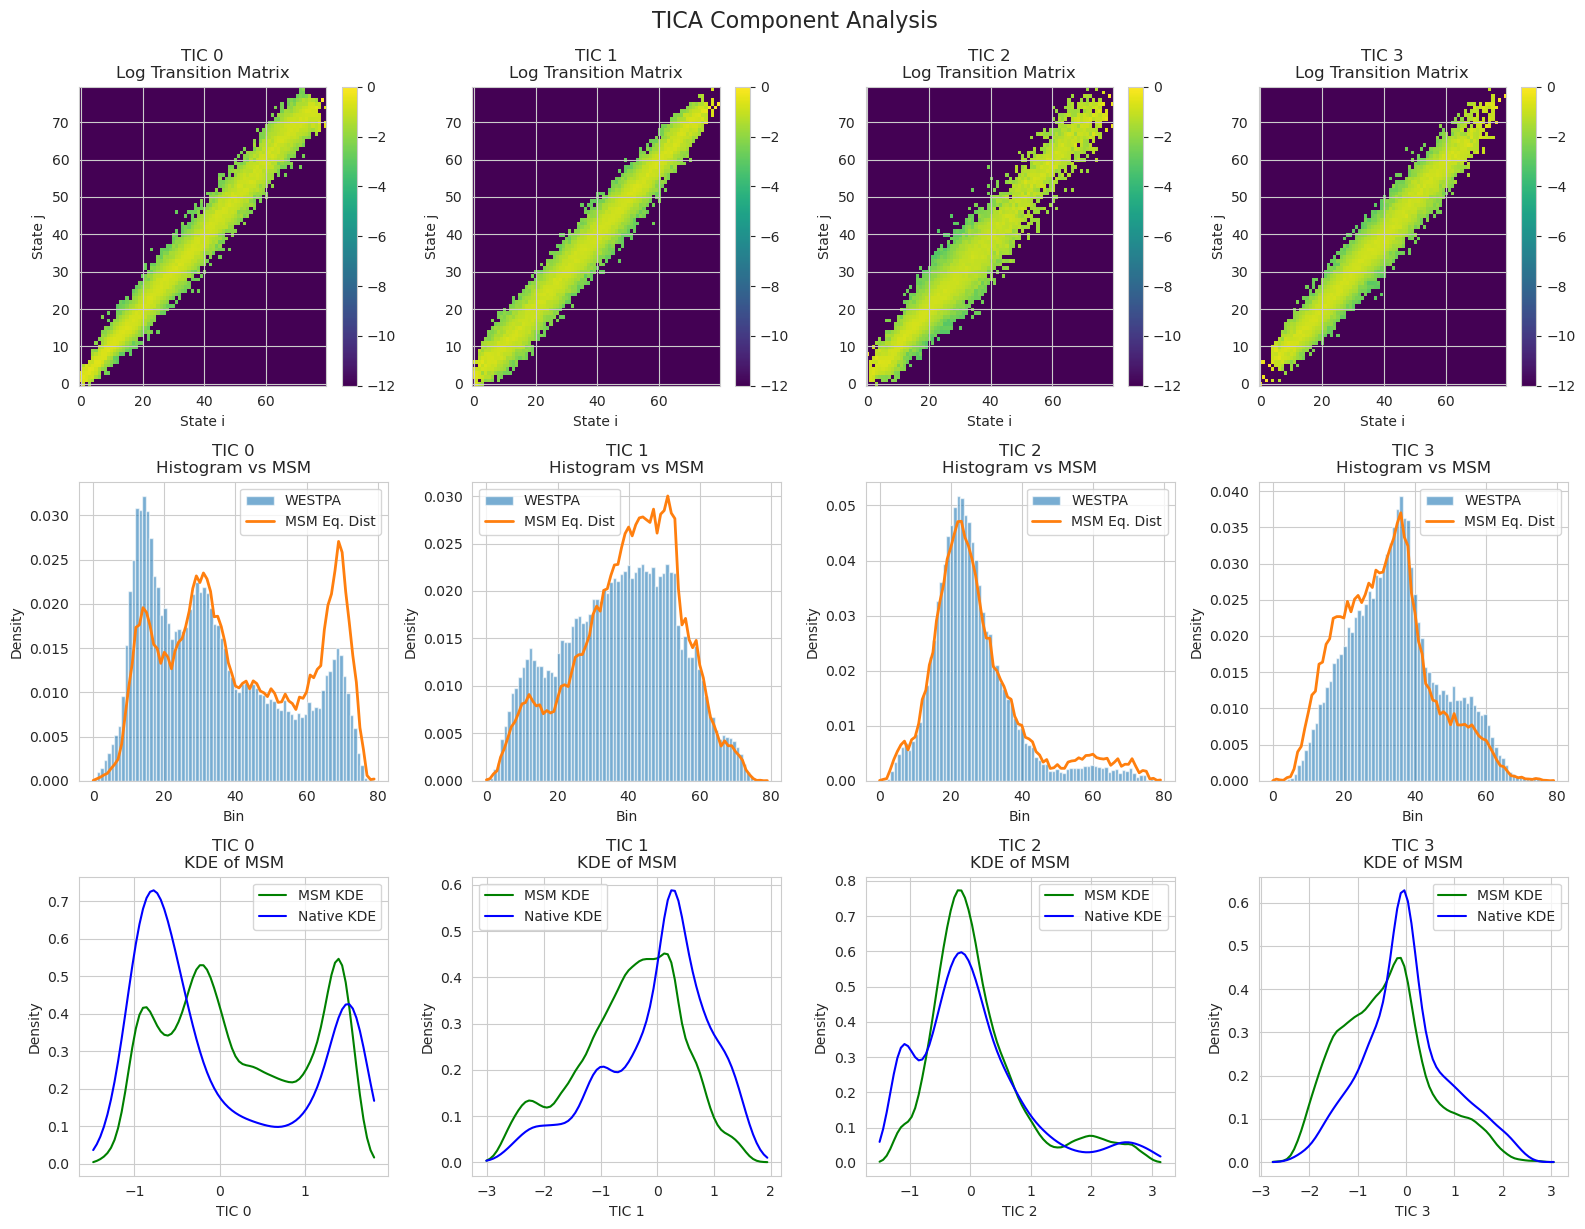

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

tica_components = [0, 1, 2, 3]

num_bins = 80
n_comps = len(tica_components)

fig, axes = plt.subplots(3, n_comps, figsize=(4 * n_comps, 12))

for i, comp in enumerate(tica_components):
    # Step 1: Calculate component values
    component_values = []
    for traj in tqdm(trajectories):
        values = calculate_component_values(tica_model, traj, [comp])
        component_series = np.array(values[comp])
        component_values.append(component_series)

    # Step 2: Bin component values
    component_min = min([min(cv) for cv in component_values])
    component_max = max([max(cv) for cv in component_values])
    component_bins = np.linspace(component_min, component_max, num_bins + 1)
    bin_centers = 0.5 * (component_bins[:-1] + component_bins[1:])

    binned_components = [
        np.clip((num_bins * (cv - component_min) / (component_max - component_min)).astype(int), None, num_bins - 1)
        for cv in component_values
    ]

    # Step 3: Build transition matrix
    transition_matrix = np.zeros((num_bins, num_bins), dtype=int)
    for binned_traj in binned_components:
        for j in range(len(binned_traj) - 1):
            transition_matrix[binned_traj[j], binned_traj[j + 1]] += 1

    # Step 4: Normalize to transition probability matrix
    transition_prob_matrix = transition_matrix.astype(np.double)
    row_sums = transition_prob_matrix.sum(axis=1, keepdims=True)
    transition_prob_matrix = np.divide(
        transition_prob_matrix, row_sums, out=np.zeros_like(transition_prob_matrix), where=row_sums != 0
    )

    # Step 5: Stationary distribution
    eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
    stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]

    if stationary_vector.shape[1] != 1:
        raise ValueError(f"Stationary distribution for component {comp} is not unique")

    stationary_distribution = stationary_vector / np.sum(stationary_vector)
    stationary_distribution = stationary_distribution.real.flatten()

    # --- Plot 1: Log Transition Matrix ---
    ax0 = axes[0, i]
    im0 = ax0.imshow(np.log10(transition_prob_matrix.T + 1e-12), origin='lower', aspect='auto', cmap='viridis')
    ax0.set_title(f'TIC {comp}\nLog Transition Matrix')
    ax0.set_xlabel('State i')
    ax0.set_ylabel('State j')
    fig.colorbar(im0, ax=ax0, orientation='vertical')

    # --- Plot 2: Histogram + MSM stationary distribution ---
    ax1 = axes[1, i]
    ax1.hist(np.concatenate(binned_components), bins=num_bins, density=True, alpha=0.6, label='WESTPA')
    ax1.plot(stationary_distribution, label='MSM Eq. Dist', linewidth=2)
    ax1.set_title(f'TIC {comp}\nHistogram vs MSM')
    ax1.set_xlabel('Bin')
    ax1.set_ylabel('Density')
    ax1.legend()

    # --- Plot 3: KDE of MSM stationary distribution ---\

    ax2 = axes[2, i]
    kde = gaussian_kde(bin_centers, weights=stationary_distribution, bw_method=0.1)
    kde_values = kde(bin_centers)
    ax2.plot(bin_centers, kde_values, label='MSM KDE', color='green')
    
    native_kde = gaussian_kde(native_proj_datas_concat[:, i].T)
    native_kde_values = native_kde(bin_centers)
    ax2.plot(bin_centers, native_kde_values, label='Native KDE', color='blue')

    ax2.set_title(f'TIC {comp}\nKDE of MSM')
    ax2.set_xlabel(f'TIC {comp}')
    ax2.set_ylabel('Density')
    ax2.legend()

# Final layout and show
plt.tight_layout()
plt.suptitle("TICA Component Analysis", y=1.02, fontsize=16)
plt.show()

In [ ]:

# Step 1: Gather TIC 0 and TIC 1 values
tic0_vals = []
tic1_vals = []

for traj in tqdm(trajectories):
    values = calculate_component_values(tica_model, traj, [0, 1])
    tic0_vals.extend(values[0])
    tic1_vals.extend(values[1])

tic0_vals = np.array(tic0_vals)
tic1_vals = np.array(tic1_vals)

# Step 2: Stack and compute MSM-weighted KDE
xy = np.vstack([tic0_vals, tic1_vals])

# Determine 2D binning to assign stationary weights
x_bins = np.linspace(tic0_vals.min(), tic0_vals.max(), num_bins + 1)
y_bins = np.linspace(tic1_vals.min(), tic1_vals.max(), num_bins + 1)

# Assign bin indices
x_indices = np.digitize(tic0_vals, x_bins) - 1
y_indices = np.digitize(tic1_vals, y_bins) - 1

# Clip to ensure they lie within [0, num_bins-1]
x_indices = np.clip(x_indices, 0, num_bins - 1)
y_indices = np.clip(y_indices, 0, num_bins - 1)

# Build 2D transition matrix (MSM)
transition_matrix_2d = np.zeros((num_bins * num_bins, num_bins * num_bins), dtype=int)
for traj in tqdm(trajectories):
    tic_vals = calculate_component_values(tica_model, traj, [0, 1])
    x_idx = np.digitize(tic_vals[0], x_bins) - 1
    y_idx = np.digitize(tic_vals[1], y_bins) - 1
    x_idx = np.clip(x_idx, 0, num_bins - 1)
    y_idx = np.clip(y_idx, 0, num_bins - 1)
    flat_idx = x_idx + num_bins * y_idx
    for i in range(len(flat_idx) - 1):
        transition_matrix_2d[flat_idx[i], flat_idx[i + 1]] += 1

# Normalize
row_sums = transition_matrix_2d.sum(axis=1, keepdims=True)
transition_probs_2d = np.divide(
    transition_matrix_2d, row_sums, out=np.zeros_like(transition_matrix_2d, dtype=float), where=row_sums != 0
)

import scipy 


eigvals, eigvecs = scipy.sparse.linalg.eigs(transition_probs_2d.T)

# Find index of eigenvalue closest to 1
idx = np.argmin(np.abs(eigvals - 1))
stationary = eigvecs[:, idx].real

# Make sure it's normalized and non-negative
stationary -= stationary.min()  # shift to make non-negative
stationary = stationary / stationary.sum()


# Assign weights to each (tic0, tic1) point
flat_idx_all = x_indices + num_bins * y_indices
weights = stationary[flat_idx_all]

# Weighted KDE
kde_2d = gaussian_kde(xy, weights=weights, bw_method=0.1)

# Step 3: Evaluate KDE on a grid
x_min, x_max = tic0_vals.min(), tic0_vals.max()
y_min, y_max = tic1_vals.min(), tic1_vals.max()

grid_size = 100
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, grid_size),
    np.linspace(y_min, y_max, grid_size)
)
positions = np.vstack([xx.ravel(), yy.ravel()])
kde_values = kde_2d(positions).reshape(xx.shape)


In [ ]:
from matplotlib.colors import ListedColormap

# Step 4: Plot styled contour
fig2, axes2 = plt.subplots(1, 1, figsize=(8, 6))

# Define levels manually for better contrast
levels = np.linspace(kde_values.min(), kde_values.max(), 15)

# Create custom colormap with white at the start
base_colors = [plt.cm.winter_r(i / (len(levels) - 2)) for i in range(len(levels) - 1)]
custom_colors = [(1.0, 1.0, 1.0, 1.0)] + base_colors  # Add white as the lowest value
cmap = ListedColormap(custom_colors)

# Plot with custom contour style
contour = axes2.contourf(
    kde_values.T,
    origin='lower',
    extent=[x_min, x_max, y_min, y_max],
    levels=levels,
    cmap=cmap,
    extend='max'
)


# Final styling
axes2.set_title("2D MSM KDE of TIC 0 vs TIC 1")
axes2.set_xlabel("TIC 0")
axes2.set_ylabel("TIC 1")
fig2.colorbar(contour, ax=axes2, label="Density")

plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from matplotlib import cm  # For colormap


# Step 4: Plot 3D surface
fig3 = plt.figure(figsize=(10, 8))
ax3 = fig3.add_subplot(111, projection='3d')

surf = ax3.plot_surface(
    xx, yy, kde_values,
    cmap=cm.winter_r,
    linewidth=0,
    antialiased=True,
    edgecolor='none'
)

ax3.set_title("3D KDE Surface of TIC 0 vs TIC 1")
ax3.set_xlabel("TIC 0")
ax3.set_ylabel("TIC 1")
ax3.set_zlabel("Density")

fig3.colorbar(surf, shrink=0.5, aspect=10, label="Density")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
from tqdm import tqdm

# === Settings ===
tica_component = 0
tica_model = load_tica_model(sim_config["tica_model_path"])
segment_size = 5  # Number of trajectories added per frame
num_bins = 80


# === Extract TICA component values ===
component_values = []
for traj in tqdm(trajectories):
    values = calculate_component_values(tica_model, traj, [tica_component])
    component_series = np.array(values[components[0]])  # Only the first component
    component_values.append(component_series)

    component_values.append(np.array(values[tica_component]))


In [ ]:

# Determine plotting range
all_data = np.concatenate(component_values)
component_min = np.min(all_data)
component_max = np.max(all_data)
bin_centers = np.linspace(component_min, component_max, num_bins)

# Optional: precompute final KDE as reference
ref_kde = gaussian_kde(all_data, bw_method=0.1)
ref_kde_values = ref_kde(bin_centers)

# === Precompute KDE frames with stride ===
kde_frames = []
stride = 100  # <-- This is the stride factor
segment_indices = range(segment_size, len(component_values) + 1, segment_size * stride)

for end in tqdm(segment_indices):
    current_data = component_values[:end]
    if len(current_data) < 2:
        continue  # KDE needs at least 2 points
    
    binned_components = [
        np.clip((num_bins * (cv - component_min) / (component_max - component_min)).astype(int), None, num_bins - 1)
        for cv in current_data
    ]
    
    try:
        # Step 4: Construct transition matrix
        transition_matrix = np.zeros((num_bins, num_bins), dtype=int)
        for binned_traj in binned_components:
            for j in range(len(binned_traj) - 1):
                transition_matrix[binned_traj[j], binned_traj[j + 1]] += 1

        transition_prob_matrix = transition_matrix.astype(np.double)/np.sum(transition_matrix, axis=1, keepdims=True)
        transition_prob_matrix = np.nan_to_num(transition_prob_matrix, nan=0.0)

    #     eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
    #     stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]
    #     print(stationary_vector)

        eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
        index = np.argmin(np.abs(eigenvalues - 1))
        stationary_vector = eigenvectors[:, index].real
        stationary_vector = np.clip(stationary_vector, 0, None)

    #     assert stationary_vector.shape[1] == 1, "Stationary distribution is not unique"

        # Normalize the stationary vector to sum to 1
        stationary_distribution /= np.sum(stationary_distribution)
        stationary_distribution = stationary_distribution.real.flatten()

        bin_centers = 0.5 * (component_bins[:-1] + component_bins[1:])
        kde = gaussian_kde(bin_centers, weights=stationary_distribution, bw_method=0.1)
        kde_values = kde(bin_centers)

        kde_frames.append(kde_values)
    except:
        continue



plt.title(f"TICA Componenent")
plt.hist(np.concatenate(binned_components), bins=num_bins, density=True, label="WESTPA observations")
plt.plot(stationary_distribution, label="MSM equilibrium density")
plt.legend()
pass

fig, ax = plt.subplots(figsize=(6, 4))
line_current, = ax.plot([], [], label="Evolving KDE", lw=2)
line_ref, = ax.plot(bin_centers, ref_kde_values, 'k--', label="Final KDE", alpha=0.5)

ax.set_xlim(component_min, component_max)
ax.set_ylim(0, max(ref_kde_values) * 1.2)
ax.set_xlabel(f"TICA Component {tica_component} Value")
ax.set_ylabel("Density")
ax.set_title(f"KDE Evolution for TICA {tica_component}")
ax.legend()

# === Animation update function ===
def update(frame_idx):
    kde_values = kde_frames[frame_idx]
    line_current.set_data(bin_centers, kde_values)
    ax.set_title(f"KDE Evolution - Frame {frame_idx + 1}/{len(kde_frames)}")
    return line_current,

# === Run animation ===
ani = animation.FuncAnimation(
    fig, update, frames=len(kde_frames), blit=False
)

# === Save animation ===
output_path = "kde_evolution_tic0.mp4"
ani.save(output_path, writer='ffmpeg', fps=10)
print(f"Saved animation to {output_path}")

In [ ]:
import glob
import os
import mdtraj as md
import numpy as np
import re
from tqdm import tqdm
from report_generator.traj_loading import NativeTrajPathH5, NativeTrajPath

# Step 1: Find all relevant .h5 files
h5_paths = sorted(glob.glob("/media/DATA_18_TB_1/andy/benchmark_set_5/trpcage/starting_pos_*/result/output_*.h5"))
pdb_paths = sorted(glob.glob("/media/DATA_18_TB_1/andy/benchmark_set_5/trpcage/starting_pos_*/processed/*_processed.pdb"))

def extract_index(path):
    match = re.search(r'starting_pos_(\d+)', path)
    if match:
        return int(match.group(1))
    raise ValueError(f"Could not extract index from path: {path}")

    
    
h5_dict = {extract_index(p): p for p in h5_paths}
pdb_dict = {extract_index(p): p for p in pdb_paths}

native_trajs: list[NativeTrajPathH5] = []

# Load trajectories
trajectories = []

for idx in tqdm(sorted(set(h5_dict.keys()))):
    native_trajs.append(NativeTrajPathH5(h5_path=h5_dict[idx], pdb_top_path=pdb_dict[idx]))

    h5_file = h5_dict[idx]
    pdb_file = pdb_dict[idx]

    try:
        traj = md.load_hdf5(h5_file)
        trajectories.append(traj)

    except Exception as e:
        print(f"Error loading index {idx}")
        print(e)

In [ ]:
from report_generator.tica_plots import TicaModel
import itertools
cache_path = "/media/DATA_18_TB_1/awaghili/native_tica"
prior_params = {"prior_configuration_name": "CA_lj_angleXCX_dihedralX", "exclusions": ["bonds", "angles", "dihedrals"], "forceterms": ["Bonds", "angles", "dihedrals", "RepulsionCG"], "fit_constraints": True, "tag_beta_turns": False}


tica_model = TicaModel(native_trajs, "trpcage", cache_path, True, 300, prior_params, 100)
components = sim_config["components"] if tica_components is None else tica_components


def calc_atom_distance(traj: mdtraj.Trajectory):
    pairs = list(itertools.combinations(range(0, traj.n_atoms), 2))
    distances = mdtraj.compute_distances(traj, pairs)
    return distances


def calculate_component_values_d(model, coordinates, components):
    # Returns an object of type list(dict(array)) : [trajectory, component, component_values_for_frames]
    component_values = {k: [] for k in components}

    pairs = np.vstack(np.triu_indices(coordinates.n_atoms, k=1)).T
    distances = calc_atom_distance(coordinates)
    tica_comps = model.tica_model.transform(distances)
    for k, v in component_values.items():
        v.extend(tica_comps[:, k])

    return component_values

component_values = []
for traj in trajectories:
    values = calculate_component_values_d(tica_model, traj, components)
    component_series = np.array(values[components[0]])  # Only the first component
    component_values.append(component_series)
    
# Step 3: Bin component values
num_bins = 80
component_min = min([min(cv) for cv in component_values])
component_max = max([max(cv) for cv in component_values])
component_bins = np.linspace(component_min, component_max, num_bins + 1)

binned_components = [
    np.clip((num_bins * (cv - component_min) / (component_max - component_min)).astype(int), None, num_bins - 1)
    for cv in component_values
]

# Step 4: Construct transition matrix
transition_matrix = np.zeros((num_bins, num_bins), dtype=int)
for binned_traj in binned_components:
    for j in range(len(binned_traj) - 1):
        transition_matrix[binned_traj[j], binned_traj[j + 1]] += 1

print("Transition matrix built.")


In [ ]:
transition_prob_matrix = transition_matrix.astype(np.double)/np.sum(transition_matrix, axis=1, keepdims=True)
transition_prob_matrix = np.nan_to_num(transition_prob_matrix, nan=0.0)

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
im0 = axes[0].imshow(transition_prob_matrix.T, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(im0, label='Transition Probability', ax=axes[0])
axes[0].set_xlabel('State i (src)')
axes[0].set_ylabel('State j (dst)')
# axes[0].set_title('Transition Matrix')

im1 = axes[1].imshow(transition_prob_matrix.T, origin='lower', aspect='auto', cmap='viridis', norm="log")
plt.colorbar(im1, label='Transition Log Probability', ax=axes[1])
axes[1].set_xlabel('State i (src)')
axes[1].set_ylabel('State j (dst)')
axes[1].set_title('')

fig.suptitle("State Transition Matrix")
pass

In [ ]:
# Linear algebra by ChatGPT
# Solve for the stationary distribution
eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]

assert stationary_vector.shape[1] == 1, "Stationary distribution is not unique"

# Normalize the stationary vector to sum to 1
stationary_distribution = stationary_vector / np.sum(stationary_vector)
stationary_distribution = stationary_distribution.real.flatten()

plt.title(f"TICA Componenent")
plt.hist(np.concatenate(binned_components), bins=num_bins, density=True, label="WESTPA observations")
plt.plot(stationary_distribution, label="MSM equilibrium density")
plt.legend()
pass